<a href="https://colab.research.google.com/github/avc9/NLPlay-with-Transformers--SoC-2021/blob/main/WEEK3_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
import sklearn
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import random
from gensim import corpora

nltk.download('punkt');
nltk.download('stopwords');

data=pd.read_csv("/content/drive/MyDrive/SOC-2021 data/IMDB Dataset.csv")


stop_words=set(stopwords.words('english'))

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

data['review']=data['review'].apply(denoise_text)

def stem_tokenizer(text):
  tokenizer=nltk.RegexpTokenizer(r"\w+")
  stemmer=PorterStemmer()
  return [stemmer.stem(word.lower()) for word in tokenizer.tokenize(text) if word.lower() not in stop_words]

data['review']=data['review'].apply(stem_tokenizer)



def make_dict(data):
    review_dict = corpora.Dictionary(data['review'])
    return review_dict


review_dict = make_dict(data)

def indexer(s): 
  return [review_dict.token2id[word] for word in s]

data["review_index"]=data["review"].apply(indexer)

def class_pre(val):
  if val=='positive':
    return 1
  else:
    return 0
data['sentiment_val']=data['sentiment'].apply(class_pre)

processed_data=data.drop(['review','sentiment'],axis=1)

def add_1_to_list(ip_list):
  op_list=[x+1 for x in ip_list]
  return op_list

processed_data["review_index"]=processed_data["review_index"].apply(add_1_to_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
print(processed_data.head(5))

                                        review_index  sentiment_val
0  [84, 98, 76, 131, 1, 87, 32, 59, 99, 34, 54, 4...              1
1  [196, 162, 174, 154, 187, 193, 166, 190, 136, ...              1
2  [251, 196, 254, 243, 190, 218, 247, 256, 242, ...              1
3  [266, 276, 162, 268, 280, 298, 302, 269, 288, ...              0
4  [349, 340, 229, 190, 342, 375, 366, 154, 131, ...              1


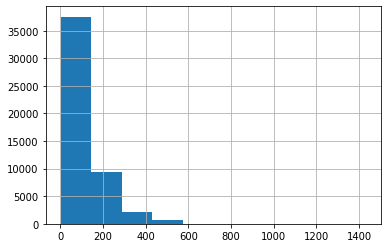

count    50000.000000
mean       119.557280
std         90.261716
min          3.000000
25%         64.000000
50%         89.000000
75%        145.000000
max       1429.000000
dtype: float64

In [90]:
rev_len=[len(lists) for lists in processed_data["review_index"] ]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [91]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [92]:
x_train,x_test,y_train,y_test = train_test_split(processed_data["review_index"],processed_data["sentiment_val"],
                                                 shuffle=True,test_size=0.3)
#print(pd.Series(y_train).value_counts())

In [93]:
x_train_pad = padding_(x_train,600)
x_test_pad = padding_(x_test,600)
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

In [94]:
print(x_train_pad[:10].shape)
print(y_train.shape)

(10, 600)
(35000,)


In [95]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import TensorDataset,DataLoader

train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=1000)
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

test_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=1000)

In [48]:
class LSTM_net(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(LSTM_net,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True,dropout=0.4)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.5)
    
        # linear and sigmoid layer
        self.fc1 = nn.Linear(self.hidden_dim, 10)
        self.fc2=nn.Linear(10,output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc1(out)
        out = self.dropout(out)
        out=self.fc2(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [49]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [70]:
no_layers = 1
vocab_size = len(review_dict) + 1 #extra 1 for padding
embedding_dim = 50
output_dim = 1
hidden_dim = 50

batch_size=1000


model = LSTM_net(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

LSTM_net(
  (embedding): Embedding(73664, 50)
  (lstm): LSTM(50, 50, batch_first=True, dropout=0.4)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=50, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
  (sig): Sigmoid()
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [71]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [72]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.0001)

In [73]:
batch_counter=1
clip = 5
epochs = 25
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    batch_counter=0
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        batch_counter+=1
        #print(f'Batch Number:{batch_counter}')
        inputs, labels = inputs.to(device), labels.to(device)   
        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        #print(f'Batch Loss :{loss.item()}')
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in test_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
           
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(test_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} train_accuracy : {epoch_train_acc}')
    print(f'test_loss : {epoch_val_loss} test_accuracy : {epoch_val_acc}')
    #print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    #print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    """if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '../working/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')"""

Epoch 1
train_loss : 0.6913550036294119 train_accuracy : 0.5224571428571428
test_loss : 0.6857662081718445 test_accuracy : 0.5540666666666667
Epoch 2
train_loss : 0.6785598039627075 train_accuracy : 0.5646285714285715
test_loss : 0.6600222667058309 test_accuracy : 0.6014666666666667
Epoch 3
train_loss : 0.6286156484058925 train_accuracy : 0.6500571428571429
test_loss : 0.5815819422403972 test_accuracy : 0.6995333333333333
Epoch 4
train_loss : 0.5296133296830313 train_accuracy : 0.7528285714285714
test_loss : 0.46072965264320376 test_accuracy : 0.7853333333333333
Epoch 5
train_loss : 0.4464524277618953 train_accuracy : 0.8090285714285714
test_loss : 0.40904833873112995 test_accuracy : 0.8172
Epoch 6
train_loss : 0.39970613036836894 train_accuracy : 0.8324571428571429
test_loss : 0.387072096268336 test_accuracy : 0.8326
Epoch 7
train_loss : 0.3774549109595163 train_accuracy : 0.8457714285714286
test_loss : 0.37723856170972186 test_accuracy : 0.8404
Epoch 8
train_loss : 0.3580682158470153

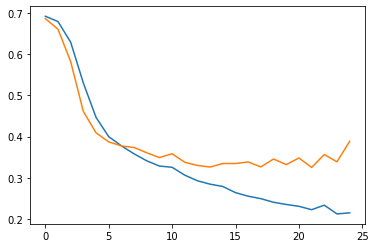

In [74]:
#x_axis=list(range(25))
%matplotlib inline
plt.plot(epoch_tr_loss)
plt.plot(epoch_vl_loss)
#plt.hold()
#plt.plot(epoch_val_loss)

In [104]:
"""class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim,embedding_dim):
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim

        #Embedding
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        # RNN
        self.rnn = nn.RNN(embedding_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc1 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, hn = self.rnn(x, h0)
        out = self.fc1(out[:, -1, :]) 
        return out"""

In [ ]:
"""input_dim = len(review_dict)+1    # input dimension
hidden_dim = 50  # hidden layer dimension
layer_dim = 1     # number of hidden layers
output_dim = 1   # output dimension
embedding_dim=50
model2 = RNNModel(input_dim, hidden_dim, layer_dim, output_dim,embedding_dim)

# Cross Entropy Loss 
error = nn.BCELoss()

# SGD Optimizer
learning_rate = 0.001
optimizer = torch.optim.SGD(model2.parameters(), lr=learning_rate)

print(model2)"""

In [ ]:
"""from torch.autograd import Variable
seq_dim = 600
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

num_epochs=10

for epoch in range(num_epochs):
    count=0
    for input, labels in train_loader:

        #train  = Variable(images.view(-1, seq_dim, input_dim))
        #labels = Variable(labels )
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model2(input.to(device))
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs.to(device), labels.float().to(device))
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1

        print(f'Epoch : {epoch} Batch : {count} Loss:{loss.item()}')
        loss_list.append(loss.item())
        
        """if count % 1 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                images = Variable(images.view(-1, seq_dim, input_dim))
                
                # Forward propagation
                outputs = model(images)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                # Print Loss
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))""""""